# March Madness Machine Learning

## Imports

In [6]:
!pip install pycaret
import os
import re
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.regression import *
from ncaa_simulator import  Submission, Tournament, Load
from sklearn.metrics import log_loss
from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.metrics import classification_report
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import xgboost as xgb
import mm_data_manipulation as dm

## Print All Files

In [7]:
DATA_PATH = '../input/mens-march-mania-2022/MDataFiles_Stage2/'

for filename in os.listdir(DATA_PATH):
    print(filename)

Conferences.csv
MMasseyOrdinals_thruDay128.csv
MNCAATourneySeedRoundSlots.csv
MRegularSeasonDetailedResults.csv
MNCAATourneyCompactResults.csv
MGameCities.csv
MSampleSubmissionStage2.csv
MSeasons.csv
MSecondaryTourneyTeams.csv
Cities.csv
MTeamSpellings.csv
MRegularSeasonCompactResults.csv
MSecondaryTourneyCompactResults.csv
MNCAATourneySlots.csv
MNCAATourneySeeds.csv
MTeamCoaches.csv
MConferenceTourneyGames.csv
MNCAATourneyDetailedResults.csv
MTeamConferences.csv
MTeams.csv


## Seeds

In [8]:
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


## Training Set

In [9]:
df = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


## Merge in Seeds

In [10]:
#Seed for Winning Team
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

#Seed for Losing Team
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

#Treat Seeds so we can read them normally
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,134,1421,92,1411,84,16,16
1,2003,136,1112,80,1436,51,1,16
2,2003,136,1113,84,1272,71,10,7
3,2003,136,1141,79,1166,73,11,6
4,2003,136,1143,76,1301,74,8,9


## Merge in Sabermetrica

In [11]:
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)

num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)

win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

df_season_results.head()

df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')

df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)
df_features_season['AvgWinningScoreMargin'] = df_features_season['AvgWinningScoreMargin'].fillna(0)
df_features_season['AvgLosingScoreMargin'] = df_features_season['AvgLosingScoreMargin'].fillna(0)

df_features_season['WinPercentage'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] - 
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

df_features_season.drop(['AvgWinningScoreMargin', 'AvgLosingScoreMargin'], axis=1, inplace=True)

df_features_season.head()

#Create New Dataframe
sabermetrics = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Offensive Rebound Percentage
sabermetrics['WOReboundPct'] = df_season_results['WOR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])
sabermetrics['LOReboundPct'] = df_season_results['LOR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])

# Defensive Rebound Percentage
sabermetrics['WDReboundPct'] = df_season_results['WDR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LDReboundPct'] = df_season_results['LDR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Assist to Turnover Ratio
sabermetrics['WATORatio'] = df_season_results['WAst'] / df_season_results['WTO']
sabermetrics['LATORatio'] = df_season_results['LAst'] / df_season_results['LTO']

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']

winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]
winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)

weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""
        
    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df

combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

metrics_list = ['Possessions', 'PtsPerPoss', 'EffectiveFGPct', 'AssistRate', 'OReboundPct', 'DReboundPct', 'ATORatio', 'TORate', 'BArcPct', 'FTRate']
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list
season_sabermetrics.sort_index(inplace=True)
season_sabermetrics.index.columns = ['Season', 'TeamID']
season_sabermetrics.reset_index(inplace=True)

season_sabermetrics.head(20)

df = df.merge(season_sabermetrics, left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'W'])
df = df.merge(season_sabermetrics, left_on=['Season', 'LTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'L'])
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate,WTeamIDL,PossessionsL,PtsPerPossL,EffectiveFGPctL,AssistRateL,OReboundPctL,DReboundPctL,ATORatioL,TORateL,BArcPctL,FTRateL
0,2003,134,1421,92,1411,84,16,16,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496


## Merge in KenPom

In [12]:
df_kenpom = pd.read_csv('../input/kenpom/kenpom_2022 (1).csv')
df_teams_spelling = pd.read_csv('../input/teams-misspelings-2/MTeamSpellings.csv')
df_teams_spelling.loc[len(df_teams_spelling.index)] = ['arkansas little rock', 1114]
df_teams_spelling.loc[len(df_teams_spelling.index)] = ['prairie view a&m;', 1341]
df_teams_spelling.loc[len(df_teams_spelling.index)] = ['texas a&m;', 1401]
df_teams_spelling.loc[len(df_teams_spelling.index)] = ['cal st. bakersfield', 1167]
df_teams_spelling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1158
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TeamNameSpelling  1159 non-null   object
 1   TeamID            1159 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.2+ KB


In [13]:
df_kenpom['TeamName'] = df_kenpom['TeamName'].str.lower()
df_kenpom = pd.merge(df_kenpom, df_teams_spelling, how='inner', left_on=["TeamName"], right_on=["TeamNameSpelling"])
df_kenpom = df_kenpom.drop(['Unnamed: 0', 'TeamNameSpelling'], 1)

df_kenpom.head()

,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d,TeamID
0,2011,ohio st.,125.4,88.4,66.0,0.043,107.4,98.3,1326
1,2012,ohio st.,116.7,83.8,68.2,-0.041,107.3,97.9,1326
2,2013,ohio st.,114.7,86.5,64.3,0.019,105.4,95.2,1326
3,2014,ohio st.,107.1,89.9,65.4,-0.028,108.2,101.6,1326
4,2015,ohio st.,111.6,94.7,66.4,-0.051,105.1,100.7,1326


In [14]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate,WTeamIDL,PossessionsL,PtsPerPossL,EffectiveFGPctL,AssistRateL,OReboundPctL,DReboundPctL,ATORatioL,TORateL,BArcPctL,FTRateL
0,2003,134,1421,92,1411,84,16,16,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496


In [15]:
#Kenpom for Winning Team
df = pd.merge(
    df, 
    df_kenpom, 
    how='inner', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamName', 'TeamID'], axis=1).rename(columns={'adj_o': 'adj_oW', 'adj_d': 'adj_dW', 'adj_tempo': 'adj_tempoW','luck': 'luckW','sos_adj_o': 'sos_adj_oW', 'sos_adj_d': 'sos_adj_dW'})

#Seed for Losing Team
df = pd.merge(
    df, 
    df_kenpom, 
    how='inner', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamName', 'TeamID'], axis=1).rename(columns={'adj_o': 'adj_oL', 'adj_d': 'adj_dL', 'adj_tempo': 'adj_tempoL','luck': 'luckL','sos_adj_o': 'sos_adj_oL', 'sos_adj_d': 'sos_adj_dL'})
df['adj_emW'] = df['adj_oW'] - df['adj_dW'] 
df['adj_emL'] = df['adj_oL'] - df['adj_dL'] 
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate,WTeamIDL,PossessionsL,PtsPerPossL,EffectiveFGPctL,AssistRateL,OReboundPctL,DReboundPctL,ATORatioL,TORateL,BArcPctL,FTRateL,adj_oW,adj_dW,adj_tempoW,luckW,sos_adj_oW,sos_adj_dW,adj_oL,adj_dL,adj_tempoL,luckL,sos_adj_oL,sos_adj_dL,adj_emW,adj_emL
0,2011,134,1155,70,1412,52,12,12,64.682500,1.057680,0.511843,0.539533,0.382216,0.743822,1.058341,0.205468,0.345405,0.401952,1412.0,64.088000,1.079749,0.509958,0.549435,0.361580,0.769296,1.228438,0.190688,0.403612,0.310547,106.5,88.7,65.0,-0.074,104.3,98.3,108.2,94.0,62.9,0.016,103.2,100.2,17.8,14.2
1,2011,134,1421,81,1114,77,16,16,70.435862,1.019799,0.493789,0.557218,0.368810,0.717522,0.961222,0.215088,0.262107,0.425622,1114.0,64.361212,1.031294,0.479156,0.510087,0.332756,0.788471,1.047007,0.181268,0.317216,0.433202,99.7,97.4,68.9,-0.031,99.8,103.3,99.5,104.4,65.4,0.044,100.6,104.3,2.3,-4.9
2,2011,135,1427,70,1106,61,16,16,67.875862,1.039555,0.495957,0.541824,0.334860,0.740932,1.030821,0.198810,0.357738,0.420143,1106.0,65.762500,0.933813,0.445727,0.550259,0.430889,0.768879,0.789237,0.239273,0.312672,0.479768,100.1,106.0,68.0,0.050,98.3,104.4,90.3,105.9,65.1,0.030,93.3,104.6,-5.9,-15.6
3,2011,135,1433,59,1425,46,11,11,65.483529,1.092862,0.509949,0.581635,0.345839,0.713721,1.324056,0.176292,0.409382,0.379127,1425.0,63.882424,1.046424,0.502500,0.502185,0.333455,0.770635,1.162866,0.177097,0.316478,0.352611,109.6,100.7,66.5,0.023,103.3,100.6,107.8,91.3,63.5,-0.042,106.8,97.8,8.9,16.5
4,2011,137,1433,74,1207,56,11,6,65.483529,1.092862,0.509949,0.581635,0.345839,0.713721,1.324056,0.176292,0.409382,0.379127,1207.0,64.490323,1.094901,0.541910,0.583475,0.361027,0.740422,1.182612,0.208460,0.364913,0.344191,109.6,100.7,66.5,0.023,103.3,100.6,113.2,94.4,64.9,0.045,109.4,95.5,8.9,18.8


## Add Symetrical Data

In [16]:
def add_losing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIDA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIDB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinPercentageW' : 'WinPercentageA',
        'WinPercentageL' : 'WinPercentageB',
        'AvgScoringMarginW' : 'AvgScoringMarginA',
        'AvgScoringMarginL' : 'AvgScoringMarginB',
        "ComputerRankW": "ComputerRankA",
        "ComputerRankL": "ComputerRankB",
        'EffectiveFGPct': 'EffectiveFGPctA',
         'PtsPerPoss': 'PtsPerPossA',
         'Possessions': 'PossessionsA',
         'AssistRate': 'AssistRateA',
         'OReboundPct': 'OReboundPctA',
         'DReboundPct': 'DReboundPctA',
         'ATORatio':'ATORatioA', 
         'TORate': 'TORateA',
         'BArcPct': 'BArcPctA',
         'FTRate': 'FTRateA',
         'PossessionsL': 'PossessionsB',
         'PtsPerPossL': 'PtsPerPossB',
         'EffectiveFGPctL': 'EffectiveFGPctB',
         'AssistRateL': 'AssistRateB',
         'OReboundPctL': 'OReboundPctB',
         'DReboundPctL': 'DReboundPctB',
         'ATORatioL': 'ATORatioB',
         'TORateL': 'TORateB',
         'BArcPctL': 'BArcPctB',
         'FTRateL': 'FTRateB',
        'adj_oW' : 'adj_oA',
        'adj_dW' : 'adj_dA',
        'adj_tempoW' : 'adj_tempoA',
        'luckW' : 'luckA', 
        'sos_adj_oW' : 'sos_adj_oA',
        'sos_adj_dW' : 'sos_adj_dA', 
        'adj_emW' : 'adj_emA',
        'adj_oL' : 'adj_oB',
        'adj_dL' : 'adj_dB',
        'adj_tempoL' : 'adj_tempoB',
        'luckL' : 'luckB', 
        'sos_adj_oL' : 'sos_adj_oB',
        'sos_adj_dL' : 'sos_adj_dB', 
        'adj_emL' : 'adj_emB'
     }
    
    lose_rename = {
        "WTeamID": "TeamIDB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIDA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'WinPercentageW' : 'WinPercentageB',
        'WinPercentageL' : 'WinPercentageA',
        'AvgScoringMarginW' : 'AvgScoringMarginB',
        'AvgScoringMarginL' : 'AvgScoringMarginA',
        "ComputerRankW": "ComputerRankB",
        "ComputerRankL": "ComputerRankA",
        "EffectiveFGPct": "EffectiveFGPctB",
        "EffectiveFGPctL": "EffectiveFGPctA",
        "PtsPerPoss": "PtsPerPossB",
         'Possessions': 'PossessionsB',
         'AssistRate': 'AssistRateB',
         'OReboundPct': 'OReboundPctB',
         'DReboundPct': 'DReboundPctB',
         'ATORatio':'ATORatioB', 
         'TORate': 'TORateB',
         'BArcPct': 'BArcPctB',
         'FTRate': 'FTRateB',
         'PossessionsL': 'PossessionsA',
         'PtsPerPossL': 'PtsPerPossA',
         'EffectiveFGPctL': 'EffectiveFGPctA',
         'AssistRateL': 'AssistRateA',
         'OReboundPctL': 'OReboundPctA',
         'DReboundPctL': 'DReboundPctA',
         'ATORatioL': 'ATORatioA',
         'TORateL': 'TORateA',
         'BArcPctL': 'BArcPctA',
         'FTRateL': 'FTRateA',
        'adj_oW' : 'adj_oB',
        'adj_dW' : 'adj_dB',
        'adj_tempoW' : 'adj_tempoB',
        'luckW' : 'luckB', 
        'sos_adj_oW' : 'sos_adj_oB',
        'sos_adj_dW' : 'sos_adj_dB', 
        'adj_emW' : 'adj_emB',
        'adj_oL' : 'adj_oA',
        'adj_dL' : 'adj_dA',
        'adj_tempoL' : 'adj_tempoA',
        'luckL' : 'luckA', 
        'sos_adj_oL' : 'sos_adj_oA',
        'sos_adj_dL' : 'sos_adj_dA', 
        'adj_emL' : 'adj_emA'
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    merged_df = pd.concat([win_df, lose_df], axis=0, sort=False)
    
    return merged_df
df = add_losing_matches(df)
df.head()
# Add final metrics
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['adj_emDiff'] = df['adj_emA'] - df['adj_emB']
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)
df = df.drop(['DayNum', 'SeedDiff', 'WTeamIDL', 'ScoreA', 'ScoreB', 'ScoreDiff'], axis=1)
pd.set_option('display.max_columns', None)
df.head()

,Season,TeamIDA,TeamIDB,SeedA,SeedB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB,adj_oA,adj_dA,adj_tempoA,luckA,sos_adj_oA,sos_adj_dA,adj_oB,adj_dB,adj_tempoB,luckB,sos_adj_oB,sos_adj_dB,adj_emA,adj_emB,adj_emDiff,WinA
0,2011,1155,1412,12,12,64.682500,1.057680,0.511843,0.539533,0.382216,0.743822,1.058341,0.205468,0.345405,0.401952,64.088000,1.079749,0.509958,0.549435,0.361580,0.769296,1.228438,0.190688,0.403612,0.310547,106.5,88.7,65.0,-0.074,104.3,98.3,108.2,94.0,62.9,0.016,103.2,100.2,17.8,14.2,3.6,1
1,2011,1421,1114,16,16,70.435862,1.019799,0.493789,0.557218,0.368810,0.717522,0.961222,0.215088,0.262107,0.425622,64.361212,1.031294,0.479156,0.510087,0.332756,0.788471,1.047007,0.181268,0.317216,0.433202,99.7,97.4,68.9,-0.031,99.8,103.3,99.5,104.4,65.4,0.044,100.6,104.3,2.3,-4.9,7.2,1
2,2011,1427,1106,16,16,67.875862,1.039555,0.495957,0.541824,0.334860,0.740932,1.030821,0.198810,0.357738,0.420143,65.762500,0.933813,0.445727,0.550259,0.430889,0.768879,0.789237,0.239273,0.312672,0.479768,100.1,106.0,68.0,0.050,98.3,104.4,90.3,105.9,65.1,0.030,93.3,104.6,-5.9,-15.6,9.7,1
3,2011,1433,1425,11,11,65.483529,1.092862,0.509949,0.581635,0.345839,0.713721,1.324056,0.176292,0.409382,0.379127,63.882424,1.046424,0.502500,0.502185,0.333455,0.770635,1.162866,0.177097,0.316478,0.352611,109.6,100.7,66.5,0.023,103.3,100.6,107.8,91.3,63.5,-0.042,106.8,97.8,8.9,16.5,-7.6,1
4,2011,1433,1207,11,6,65.483529,1.092862,0.509949,0.581635,0.345839,0.713721,1.324056,0.176292,0.409382,0.379127,64.490323,1.094901,0.541910,0.583475,0.361027,0.740422,1.182612,0.208460,0.364913,0.344191,109.6,100.7,66.5,0.023,103.3,100.6,113.2,94.4,64.9,0.045,109.4,95.5,8.9,18.8,-9.9,1


# Train Test Split

In [17]:
df_test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage2.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

#Merge in Seeds
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

#Treat Seeds so we can read them normally
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

#Merge in Season Features (Win/Loss%, Scoring Margin)
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginA',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginA',
    'WinPercentage': 'WinPercentageA',
    'AvgScoringMargin': 'AvgScoringMarginA',
    'EffectiveFGPct': 'EffectiveFGPctA',
    'PtsPerPoss': 'PtsPerPossA',
    'Possessions': 'PossessionsA',
    'AssistRate': 'AssistRateA',
    'OReboundPct': 'OReboundPctA',
    'DReboundPct': 'DReboundPctA',
    'ATORatio':'ATORatioA', 
    'TORate': 'TORateA',
    'BArcPct': 'BArcPctA',
    'FTRate': 'FTRateA'
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginB',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginB',
    'WinPercentage': 'WinPercentageB',
    'AvgScoringMargin': 'AvgScoringMarginB',
    'PossessionsL': 'PossessionsB',
    'PtsPerPossL': 'PtsPerPossB',
    'EffectiveFGPctL': 'EffectiveFGPctB',
    'AssistRateL': 'AssistRateB',
    'OReboundPctL': 'OReboundPctB',
    'DReboundPctL': 'DReboundPctB',
    'ATORatioL': 'ATORatioB',
    'TORateL': 'TORateB',
    'BArcPctL': 'BArcPctB',
    'FTRateL': 'FTRateB'
    
}).drop(columns='TeamID', axis=1)

# MErge in Sabermetrics
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDA'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'A'])
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDB'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'B'])
df_test = df_test.rename(columns={'EffectiveFGPct': 'EffectiveFGPctA',
                                 'PtsPerPoss': 'PtsPerPossA',
                                 'Possessions': 'PossessionsA',
                                 'AssistRate': 'AssistRateA',
                                 'OReboundPct': 'OReboundPctA',
                                 'DReboundPct': 'DReboundPctA',
                                 'ATORatio':'ATORatioA', 
                                 'TORate': 'TORateA',
                                 'BArcPct': 'BArcPctA',
                                 'FTRate': 'FTRateA',
                                 'PossessionsL': 'PossessionsB',
                                 'PtsPerPossL': 'PtsPerPossB',
                                 'EffectiveFGPctL': 'EffectiveFGPctB',
                                 'AssistRateL': 'AssistRateB',
                                 'OReboundPctL': 'OReboundPctB',
                                 'DReboundPctL': 'DReboundPctB',
                                 'ATORateL': 'ATORatioB',
                                 'TORateL': 'TORateB',
                                 'BArcPctL': 'BArcPctB',
                                 'FTRateL': 'FTRateB'})

df_test = df_test.merge(df_kenpom, left_on=['Season', 'TeamIDA'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, 'A']).drop(['TeamID', 'TeamName'], 1)
df_test = df_test.merge(df_kenpom, left_on=['Season', 'TeamIDB'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, 'B']).drop(['TeamID', 'TeamName'], 1)
df_test = df_test.rename(columns={'adj_o' : 'adj_oA',
        'adj_d' : 'adj_dA',
        'adj_tempo' : 'adj_tempoA',
        'luck' : 'luckA', 
        'sos_adj_o' : 'sos_adj_oA',
        'sos_adj_d' : 'sos_adj_dA', 
        'adj_em' : 'adj_emA',})

df_test['adj_emA'] = df_test['adj_oA'] - df_test['adj_dA']
df_test['adj_emB'] = df_test['adj_oB'] - df_test['adj_dB']
df_test['adj_emDiff'] = df_test['adj_emA'] - df_test['adj_emB']
pd.set_option('display.max_columns', None)
df_test.head()

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,WTeamID,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,WTeamIDB,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB,adj_oA,adj_dA,adj_tempoA,luckA,sos_adj_oA,sos_adj_dA,adj_oB,adj_dB,adj_tempoB,luckB,sos_adj_oB,sos_adj_dB,adj_emA,adj_emB,adj_emDiff
0,2022_1103_1104,0.5,2022,1103,1104,13,6,22.0,9.0,0.709677,5.129032,19.0,13.0,0.593750,3.562500,1103.0,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,1104.0,74.486250,1.078883,0.515820,0.528441,0.330464,0.710964,1.153804,0.188736,0.477769,0.343385,106.2,102.7,62.1,0.026,100.8,106.0,116.1,98.7,71.7,-0.022,109.7,96.9,3.5,17.4,-13.9
1,2022_1103_1112,0.5,2022,1103,1112,13,1,22.0,9.0,0.709677,5.129032,31.0,3.0,0.911765,17.029412,1103.0,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,1112.0,73.368235,1.154467,0.560850,0.653862,0.334137,0.718400,1.717451,0.175129,0.356882,0.363532,106.2,102.7,62.1,0.026,100.8,106.0,119.6,92.4,72.2,0.046,106.0,99.7,3.5,27.2,-23.7
2,2022_1103_1116,0.5,2022,1103,1116,13,4,22.0,9.0,0.709677,5.129032,25.0,8.0,0.757576,8.393939,1103.0,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,1116.0,73.167273,1.052555,0.491808,0.523306,0.284028,0.757240,1.317591,0.165909,0.344243,0.385605,106.2,102.7,62.1,0.026,100.8,106.0,111.1,92.1,70.6,0.027,106.8,98.9,3.5,19.0,-15.5
3,2022_1103_1120,0.5,2022,1103,1120,13,2,22.0,9.0,0.709677,5.129032,27.0,5.0,0.843750,11.687500,1103.0,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,1120.0,73.841250,1.065858,0.507241,0.517973,0.280617,0.713856,1.421259,0.157643,0.396218,0.325992,106.2,102.7,62.1,0.026,100.8,106.0,113.6,89.1,70.0,-0.039,107.2,98.5,3.5,24.5,-21.0
4,2022_1103_1124,0.5,2022,1103,1124,13,1,22.0,9.0,0.709677,5.129032,26.0,6.0,0.812500,12.875000,1103.0,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,1124.0,69.551250,1.099434,0.529770,0.554559,0.340715,0.714922,1.404533,0.172747,0.377161,0.293017,106.2,102.7,62.1,0.026,100.8,106.0,117.9,91.6,67.2,0.019,107.4,96.7,3.5,26.3,-22.8


# Final Cleanup

In [18]:
df_test = df_test.drop(['WTeamID', 'WTeamIDB'], axis=1)
df_test.head()

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB,adj_oA,adj_dA,adj_tempoA,luckA,sos_adj_oA,sos_adj_dA,adj_oB,adj_dB,adj_tempoB,luckB,sos_adj_oB,sos_adj_dB,adj_emA,adj_emB,adj_emDiff
0,2022_1103_1104,0.5,2022,1103,1104,13,6,22.0,9.0,0.709677,5.129032,19.0,13.0,0.593750,3.562500,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,74.486250,1.078883,0.515820,0.528441,0.330464,0.710964,1.153804,0.188736,0.477769,0.343385,106.2,102.7,62.1,0.026,100.8,106.0,116.1,98.7,71.7,-0.022,109.7,96.9,3.5,17.4,-13.9
1,2022_1103_1112,0.5,2022,1103,1112,13,1,22.0,9.0,0.709677,5.129032,31.0,3.0,0.911765,17.029412,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,73.368235,1.154467,0.560850,0.653862,0.334137,0.718400,1.717451,0.175129,0.356882,0.363532,106.2,102.7,62.1,0.026,100.8,106.0,119.6,92.4,72.2,0.046,106.0,99.7,3.5,27.2,-23.7
2,2022_1103_1116,0.5,2022,1103,1116,13,4,22.0,9.0,0.709677,5.129032,25.0,8.0,0.757576,8.393939,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,73.167273,1.052555,0.491808,0.523306,0.284028,0.757240,1.317591,0.165909,0.344243,0.385605,106.2,102.7,62.1,0.026,100.8,106.0,111.1,92.1,70.6,0.027,106.8,98.9,3.5,19.0,-15.5
3,2022_1103_1120,0.5,2022,1103,1120,13,2,22.0,9.0,0.709677,5.129032,27.0,5.0,0.843750,11.687500,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,73.841250,1.065858,0.507241,0.517973,0.280617,0.713856,1.421259,0.157643,0.396218,0.325992,106.2,102.7,62.1,0.026,100.8,106.0,113.6,89.1,70.0,-0.039,107.2,98.5,3.5,24.5,-21.0
4,2022_1103_1124,0.5,2022,1103,1124,13,1,22.0,9.0,0.709677,5.129032,26.0,6.0,0.812500,12.875000,64.104516,1.080044,0.531191,0.490467,0.282216,0.762717,1.128033,0.169435,0.416506,0.415477,69.551250,1.099434,0.529770,0.554559,0.340715,0.714922,1.404533,0.172747,0.377161,0.293017,106.2,102.7,62.1,0.026,100.8,106.0,117.9,91.6,67.2,0.019,107.4,96.7,3.5,26.3,-22.8


# Pycaret Model

In [19]:
"""
model = setup(
    df, 
    target = 'WinA',
    feature_selection = True,
    log_experiment = True,
    transformation = True,
    normalize = True, use_gpu=True,
    remove_multicollinearity = True,
    ignore_features = ['Season', 'TeamIDA', 'TeamIDB']
)
"""
model = setup(
    df,
    target = 'WinA',
    session_id=123, 
    log_experiment=False, 
    experiment_name='experiment1',
    normalize=True,
    normalize_method='robust',
    imputation_type="iterative", 
    categorical_iterative_imputer="lightgbm", 
    numeric_iterative_imputer="lightgbm", 
    iterative_imputation_iters = 5,
    polynomial_features = False, 
    polynomial_degree = 3, 
    polynomial_threshold = 0.1,
    feature_interaction = True, 
    feature_ratio = True, 
    interaction_threshold = 0.01,
    #remove_outliers = True, 
    remove_outliers = False, 
    outliers_threshold = 0.05, 
    #remove_multicollinearity = True, 
    remove_multicollinearity = False, 
    multicollinearity_threshold = 0.8, 
    remove_perfect_collinearity = False, 
    pca = False, 
    pca_method='linear', 
    pca_components = .95, 
    feature_selection = False, 
    feature_selection_threshold=.8, 
    feature_selection_method='boruta', 
    train_size = .8, 
    use_gpu=True, 
    n_jobs=-1,
    ignore_features = ['Season', 'TeamIDA', 'TeamIDB']
             #,ignore_features= ['']
             )

,Description,Value
0,session_id,123
1,Target,WinA
2,Original Data,"(1316, 41)"
3,Missing Values,False
4,Numeric Features,35
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1052, 186)"


In [20]:
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)

Name                                                        LogLoss
Display Name                                                LogLoss
Score Function                <function log_loss at 0x7f4fa0429c20>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Custom                                                         True
Name: logloss, dtype: object

In [21]:
#find best model
#best = compare_models()

#best = create_model('lar')

# train a few models
#et = create_model('et')
rf = create_model('rf')
#ada = create_model('ada')
#xgb = create_model('xgboost')


# blend models
#best = blend_models([et, rf, ada])
best = rf

#best = ensemble_model(et, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,LogLoss
0,0.3678,0.1820,0.4266,0.2591,0.3024,0.3888,0.5337
1,0.4188,0.2193,0.4683,0.0966,0.3158,0.4544,0.6296
2,0.3878,0.1911,0.4371,0.2300,0.3025,0.3837,0.5885
3,0.3874,0.1900,0.4359,0.2143,0.3137,0.3853,0.5628
4,0.3946,0.2005,0.4478,0.1921,0.3113,0.3959,0.5860
5,0.3917,0.2071,0.4551,0.1588,0.3280,0.3322,0.6057
6,0.3859,0.2048,0.4526,0.1637,0.3193,0.4251,0.5878
7,0.3472,0.1625,0.4031,0.3501,0.2802,0.3571,0.4942
8,0.3792,0.1792,0.4233,0.2801,0.2957,0.3825,0.5399
9,0.3394,0.1530,0.3911,0.3836,0.2734,0.3311,0.4755


In [ ]:
evaluate_model(best)

In [22]:
best = tune_model(best, optimize = 'LogLoss', choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,LogLoss
0,0.3869,0.1831,0.4279,0.2547,0.3061,0.4074,0.5448
1,0.4178,0.2076,0.4557,0.1448,0.3073,0.4456,0.6009
2,0.4072,0.1983,0.4453,0.2010,0.3085,0.4007,0.5964
3,0.4057,0.1970,0.4439,0.1852,0.3217,0.3957,0.5730
4,0.4108,0.2054,0.4532,0.1722,0.3169,0.4012,0.5962
5,0.4306,0.2268,0.4763,0.0786,0.3417,0.3911,0.6472
6,0.4040,0.2021,0.4495,0.1748,0.3177,0.4335,0.5845
7,0.3712,0.1693,0.4114,0.3229,0.2870,0.3904,0.5133
8,0.4022,0.1920,0.4382,0.2286,0.3043,0.4118,0.5699
9,0.3634,0.1618,0.4022,0.3481,0.2830,0.3454,0.4951


In [23]:
predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,LogLoss
0,Random Forest Regressor,0.3985,0.2074,0.4555,0.1690,0.3182,0.3946,0.5980


,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,...,adj_tempoA_multiply_ATORatioA,sos_adj_oB_divide_AssistRateB,luckA_divide_adj_oB,PtsPerPossB_divide_FTRateB,BArcPctA_multiply_PossessionsA,ATORatioB_divide_TORateB,SeedA_1_multiply_EffectiveFGPctA,OReboundPctA_divide_luckB,WinA,Label
0,0.559999,0.838791,1.458408,0.410417,-0.560590,-0.953005,0.551689,-0.265501,0.972336,-1.330549,...,0.268770,2.472452,0.695055,-5.302692,0.544508,4.020423,1.458408,0.672707,1,0.410187
1,0.774904,-0.574130,0.049618,-0.816142,-0.384398,0.126707,-0.678410,0.528132,0.011286,-0.534414,...,-0.539249,-3.312366,1.669356,-0.598232,0.008745,2.662574,0.000000,1.596732,0,0.330584
2,0.352939,-1.121255,-0.886716,-2.151491,0.317635,0.240665,-1.367639,1.114095,-0.566635,0.401175,...,-0.140268,1.632641,6.229182,-0.130277,-0.199988,-0.915085,-0.000000,1.429358,0,0.040751
3,0.852262,0.094755,0.482419,-0.944612,-0.957917,1.024531,0.204664,-0.677869,0.349418,-1.407646,...,0.068221,1.013765,-0.777424,-12.605671,0.297795,-1.703327,0.000000,3.979041,0,0.160813
4,0.710253,0.309583,-0.430433,-2.083967,-0.385865,-0.284603,-0.310115,-1.511613,-0.067735,0.877111,...,-0.421438,0.426880,1.584935,-1.264181,-0.048109,-11.662629,-0.000000,0.833468,0,0.070547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.310990,0.323751,-0.272201,-0.790585,0.535813,0.441930,0.081965,-0.505784,-0.359981,-0.333777,...,0.021017,-1.603564,-0.491297,-1.081614,-0.111951,-0.820930,-0.000000,-0.578678,0,0.728324
260,-0.178975,-0.301653,0.152336,-0.036863,-0.200092,-0.043837,-0.341136,0.246053,0.119387,1.408120,...,0.174942,-2.222444,0.278918,-1.643377,-0.021367,-0.249819,0.000000,-5.402501,0,0.090463
261,-0.387784,0.452208,-0.095925,0.541378,0.587196,-2.222831,0.829004,-0.583918,-0.510625,-0.664510,...,-0.191309,0.168173,-6.900000,0.453068,0.198012,-0.074427,-0.095925,-1.219562,1,0.549499
262,-1.464232,-1.314375,-1.408371,-1.177083,0.618825,-0.899675,-0.869814,0.442385,-0.678840,-0.092034,...,1.360479,-5.406353,-0.033430,3.578337,0.993979,-1.712714,-0.000000,0.655227,0,0.290491


In [24]:
predictions = predict_model(best, data=df_test)
predictions.head()

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,...,adj_oB,adj_dB,adj_tempoB,luckB,sos_adj_oB,sos_adj_dB,adj_emA,adj_emB,adj_emDiff,Label
0,2022_1103_1104,0.5,2022,1103,1104,13,6,22.0,9.0,0.709677,...,116.1,98.7,71.7,-0.022,109.7,96.9,3.5,17.4,-13.9,0.130640
1,2022_1103_1112,0.5,2022,1103,1112,13,1,22.0,9.0,0.709677,...,119.6,92.4,72.2,0.046,106.0,99.7,3.5,27.2,-23.7,0.460000
2,2022_1103_1116,0.5,2022,1103,1116,13,4,22.0,9.0,0.709677,...,111.1,92.1,70.6,0.027,106.8,98.9,3.5,19.0,-15.5,0.202407
3,2022_1103_1120,0.5,2022,1103,1120,13,2,22.0,9.0,0.709677,...,113.6,89.1,70.0,-0.039,107.2,98.5,3.5,24.5,-21.0,0.100666
4,2022_1103_1124,0.5,2022,1103,1124,13,1,22.0,9.0,0.709677,...,117.9,91.6,67.2,0.019,107.4,96.7,3.5,26.3,-22.8,0.040620


In [25]:
sub = df_test[['ID']].copy()
sub['Pred'] = predictions['Label']
sub.to_csv('submission.csv', index=False)
sub.head()
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2278 non-null   object 
 1   Pred    2278 non-null   float64
dtypes: float64(1), object(1)
memory usage: 53.4+ KB


## Visualize Predictions

In [26]:
mw = 'm'
ncaa_files = Load(mw, dir='../input/mens-march-mania-2022/MDataFiles_Stage2')

## load your submission file
df = pd.read_csv('./submission.csv')
submission = Submission(sub_df=df, files=ncaa_files)

print('available seasons from submission: ', submission.seasons)
tourney = Tournament(files=ncaa_files,submission=submission,season=2022)

available seasons from submission:  [2022]


## Chalk

In [27]:
tourney.simulate_tournament(style='chalk') 
tourney.summary_to_df()

,Team,First Round,Round of 32,Sweet 16,Elite 8,Final 4,Championship,Winner
TeamID,,,,,,,,
1211,X01 - Gonzaga,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1222,Z05 - Houston,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1242,Y01 - Kansas,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1246,W02 - Kentucky,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1397,Z03 - Tennessee,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1120,Y02 - Auburn,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1181,X02 - Duke,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1124,W01 - Baylor,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1437,Z02 - Villanova,1.0,1.0,1.0,0.0,0.0,0.0,0.0


## Random Run

In [29]:
tourney.reset_tournament()
tourney.simulate_tournament('random', seed=69) 
tourney.summary_to_df()

,Team,First Round,Round of 32,Sweet 16,Elite 8,Final 4,Championship,Winner
TeamID,,,,,,,,
1181,X02 - Duke,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1120,Y02 - Auburn,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1397,Z03 - Tennessee,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1124,W01 - Baylor,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1112,Z01 - Arizona,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1234,Y05 - Iowa,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1163,X05 - Connecticut,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1345,W03 - Purdue,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1260,Z10 - Loyola-Chicago,1.0,1.0,1.0,0.0,0.0,0.0,0.0


## Simulation (n runs)

In [30]:
n_sim = 1000
results = tourney.simulate_tournaments(n_sim)

In [35]:
pd.set_option('display.max_rows', None)
odds = results.copy()
odds.iloc[:,1:] = (results.iloc[:,1:]  / n_sim) * 100
odds.sort_values(by=['Winner'], ascending=False).head(68)


,Team,First Round,Round of 32,Sweet 16,Elite 8,Final 4,Championship,Winner
TeamID,,,,,,,,
1211,X01 - Gonzaga,100.0,83.7,69.6,53.6,39.3,26.6,18.7
1246,W02 - Kentucky,100.0,92.2,73.5,52.0,32.1,16.4,10.6
1242,Y01 - Kansas,100.0,67.4,44.8,37.1,28.4,18.2,9.9
1124,W01 - Baylor,100.0,88.5,66.2,45.9,26.1,13.3,8.3
1222,Z05 - Houston,100.0,82.0,62.1,39.4,26.2,14.8,7.4
1181,X02 - Duke,100.0,89.7,72.2,51.4,27.5,13.8,6.3
1112,Z01 - Arizona,100.0,80.8,50.4,26.1,15.6,10.1,5.2
1397,Z03 - Tennessee,100.0,80.1,61.5,41.7,18.3,10.3,4.3
1437,Z02 - Villanova,100.0,73.3,54.1,31.8,17.9,8.3,3.5


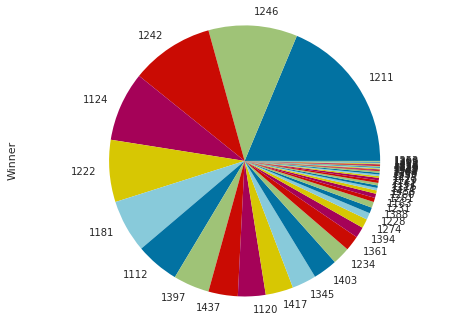

In [36]:
odds['Winner'].plot(kind='pie')
plt.axis('equal')
plt.show()